<a href="https://colab.research.google.com/github/221sakshisharma/coursera-ML-work/blob/main/DBSCAN_HDBSCAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy
!pip install pandas
!pip install scikit-learn
!pip install matplotlib
!pip install hdbscan
!pip install geopandas
!pip install contextily
!pip install shapely

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 98.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.preprocessing import StandardScaler

import geopandas as gpd  # pandas dataframe-like geodataframes for geographical data
import contextily as ctx  # used for obtianing a basemap of Canada
from shapely.geometry import Point

%matplotlib inline

In [ ]:
import requests
import zipfile
import io
import os

# URL of the ZIP file on the cloud server
zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip'

# Directory to save the extracted TIFF file
output_dir = './'
os.makedirs(output_dir, exist_ok=True)

# Step 1: Download the ZIP file
response = requests.get(zip_file_url)
response.raise_for_status()  # Ensure the request was successful
# Step 2: Open the ZIP file in memory
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    # Step 3: Iterate over the files in the ZIP
    for file_name in zip_ref.namelist():
        if file_name.endswith('.tif'):  # Check if it's a TIFF file
            # Step 4: Extract the TIFF file
            zip_ref.extract(file_name, output_dir)
            print(f"Downloaded and extracted: {file_name}")

Downloaded and extracted: Canada.tif


In [125]:
# Write a function that plots clustered locations and overlays them on a basemap.

def plot_clustered_locations(df,  title='Museums Clustered by Proximity'):


    # Load the coordinates intto a GeoDataFrame
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['Longitude'], df['Latitude']), crs="EPSG:4326")

    # Reproject to Web Mercator to align with basemap
    gdf = gdf.to_crs(epsg=3857)

    # Create the plot
    fig, ax = plt.subplots(figsize=(15, 10))

    # Separate non-noise, or clustered points from noise, or unclustered points
    non_noise = gdf[gdf['Cluster'] != -1]
    noise = gdf[gdf['Cluster'] == -1]

    # Plot noise points
    # noise.plot(ax=ax, color='k', markersize=30, ec='r', alpha=1, label='Noise')

    # Plot clustered points, colured by 'Cluster' number
    non_noise.plot(ax=ax, column='Cluster', cmap='tab10', markersize=30, ec='k', legend=False, alpha=0.6)

    # Add basemap of  Canada
    ctx.add_basemap(ax, source='./Canada.tif', zoom=4)

    # Format plot
    plt.title(title, )
    plt.xlabel('Longitude', )
    plt.ylabel('Latitude', )
    ax.set_xticks([])
    ax.set_yticks([])
    plt.tight_layout()

    # Show the plot
    plt.show()

In [89]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv'
df = pd.read_csv(url, encoding = "ISO-8859-1")

In [90]:
df.head()

,Index,Facility_Name,Source_Facility_Type,ODCAF_Facility_Type,Provider,Unit,Street_No,Street_Name,Postal_Code,City,Prov_Terr,Source_Format_Address,CSD_Name,CSDUID,PRUID,Latitude,Longitude
0,1,#Hashtag Gallery,..,gallery,toronto,..,801,dundas st w,M6J 1V2,toronto,on,801 dundas st w,Toronto,3520005,35,43.65169472,-79.40803272
1,2,'Ksan Historical Village & Museum,historic site-building or park,museum,canadian museums association,..,1500,62 hwy,V0J 1Y0,hazelton,bc,1500 hwy 62 hazelton british columbia v0j 1y0 ...,Hazelton,5949022,59,55.2645508,-127.6428124
2,3,'School Days' Museum,community/regional museum,museum,canadian museums association,..,427,queen st,E3B 5R6,fredericton,nb,427 queen st fredericton new brunswick e3b 5r6...,Fredericton,1310032,13,45.963283,-66.6419017
3,4,10 Austin Street,built heritage properties,heritage or historic site,moncton,..,10,austin st,E1C 1Z6,moncton,nb,10 austin st,Moncton,1307022,13,46.09247776,-64.78022946
4,5,10 Gates Dancing Inc.,arts,miscellaneous,ottawa,..,..,..,..,ottawa,on,..,Ottawa,3506008,35,45.40856224,-75.71536766


In [91]:
df.shape

(7972, 17)

In [92]:
df = df[df["ODCAF_Facility_Type"] == "museum"]

In [93]:
df.shape

(1938, 17)

In [94]:
df = df[(df["Latitude"] != "..") & (df["Longitude"] != "..")]

In [95]:
X = df[["Latitude", "Longitude"]].astype(float)

In [96]:
X.describe()

,Latitude,Longitude
count,1607.000000,1607.000000
mean,47.411530,-87.168398
std,3.350575,21.216091
min,41.737209,-139.431695
25%,45.107361,-107.037202
50%,46.435102,-79.385571
75%,49.511766,-72.511322
max,67.029613,-52.684217


#DBSCAN

In [99]:
# In this case we know how to scale the coordinates. Using standardization would be an error becaues we aren't using the full range of the lat/lng coordinates.
# Since latitude has a range of +/- 90 degrees and longitude ranges from 0 to 360 degrees, the correct scaling is to double the longitude coordinates (or half the Latitudes)
coords_scaled = X.copy()
coords_scaled["Latitude"] = 2*coords_scaled["Latitude"]

In [101]:
coords_scaled.describe()

,Latitude,Longitude
count,1607.000000,1607.000000
mean,94.823061,-87.168398
std,6.701150,21.216091
min,83.474419,-139.431695
25%,90.214722,-107.037202
50%,92.870203,-79.385571
75%,99.023531,-72.511322
max,134.059225,-52.684217


Setting Parameters for DBSCAN

In [104]:
n = 3 # min no. of samples needed to form a neigbourhood
epsilon = 1.0 # neighbourshood search radius
metric = 'euclidean'

In [105]:
dbscan = DBSCAN(eps=epsilon, min_samples=n, metric=metric).fit(coords_scaled)

In [106]:
dbscan

DBSCAN(eps=1.0, min_samples=3)

In [108]:
df['Cluster'] = dbscan.fit_predict(coords_scaled)  # Assign the cluster labels


In [110]:
df

,Index,Facility_Name,Source_Facility_Type,ODCAF_Facility_Type,Provider,Unit,Street_No,Street_Name,Postal_Code,City,Prov_Terr,Source_Format_Address,CSD_Name,CSDUID,PRUID,Latitude,Longitude,Cluster
1,2,'Ksan Historical Village & Museum,historic site-building or park,museum,canadian museums association,..,1500,62 hwy,V0J 1Y0,hazelton,bc,1500 hwy 62 hazelton british columbia v0j 1y0 ...,Hazelton,5949022,59,55.2645508,-127.6428124,0
2,3,'School Days' Museum,community/regional museum,museum,canadian museums association,..,427,queen st,E3B 5R6,fredericton,nb,427 queen st fredericton new brunswick e3b 5r6...,Fredericton,1310032,13,45.963283,-66.6419017,1
8,10,12 Service Battalion Museum,military museum or fort,museum,canadian museums association,..,5500,no 4 rd,V6X 3L5,richmond,bc,5500 no. 4 rd the sherman armoury richmond bri...,Richmond,5915015,59,49.1763542,-123.112783,2
13,15,15th Field Artillery Regiment Museum And Archives,museum/gallery,museum,vancouver,..,2025,11th av w,V6J 2C7,vancouver,bc,2025 w 11th av vancouver bc v6j 2c7,Vancouver,5915022,59,49.261938,-123.151123,2
15,18,17 Wing Heritage Collection,aeronautics and space museum transportation mu...,museum,canadian museums association,..,..,..,R3J 3Y5,winnipeg,mb,air heritage park air force way winnipeg manit...,Winnipeg,4611040,46,49.88955855,-97.23574396,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7934,9759,YMCA of Niagara Children's Discovery Centre,..,museum,niagara region,..,360,niagara st n,..,st catharines,on,360 niagara st n,St. Catharines,3526053,35,43.18308983,-79.2245641,4
7936,9761,York Museum,community/regional museum,museum,canadian museums association,..,2694,eglinton avenue west,M6M 1V1,york,on,2694 eglinton avenue west york ontario m6m 1v1...,Toronto,3520005,35,43.6900216,-79.476208,4
7940,9765,York Region District School Board Museum & Arc...,library and/or archives community/regional museum,museum,canadian museums association,..,21,renfrew dr,L3R 8H3,markham,on,21 renfrew dr markham ontario l3r 8h3 canada,Markham,3519036,35,43.857692,-79.3619396,4
7968,9797,Craigdarroch Castle,museums and galleries,museum,victoria,..,..,..,..,victoria,bc,..,Victoria,5917034,59,48.42241956,-123.3435527,2


In [111]:
df['Cluster'].value_counts()

,count
Cluster,
4,701
2,192
1,181
7,134
3,94
-1,79
6,30
10,27
8,21


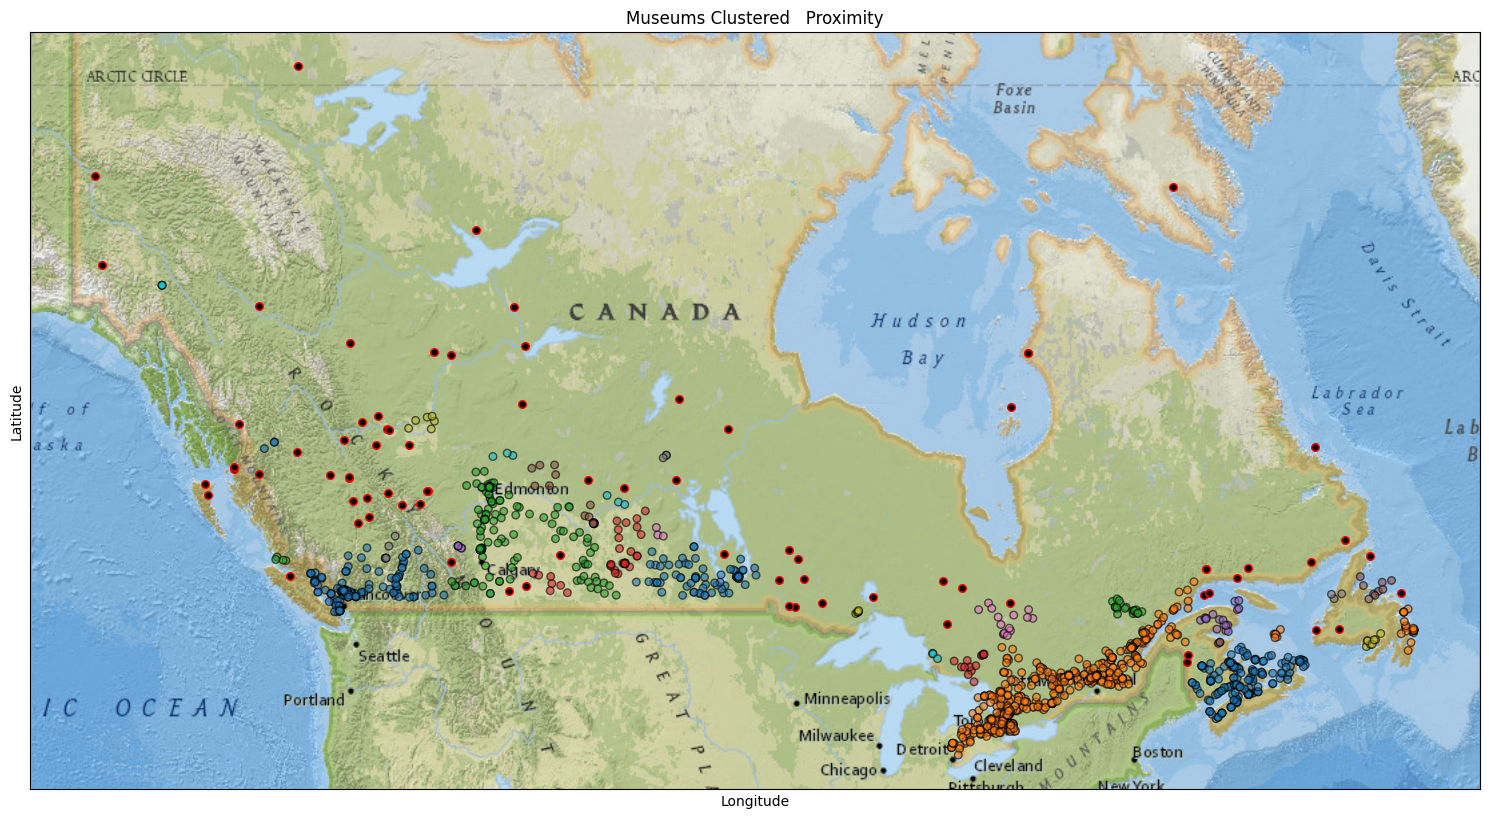

In [113]:
plot_clustered_locations(df, title='Museums Clustered   Proximity')

#HBDSCAN

https://hdbscan.readthedocs.io/en/latest/parameter_selection.html

In [114]:
min_samples=None # if none is given the min samples will be equal to min cluster size
min_cluster_size=3


In [115]:
hdb = hdbscan.HDBSCAN(min_samples=min_samples, min_cluster_size=min_cluster_size, metric='euclidean')

In [119]:
hdb.fit(coords_scaled)


HDBSCAN(min_cluster_size=3)

In [122]:
df["Cluster"] = hdb.labels_

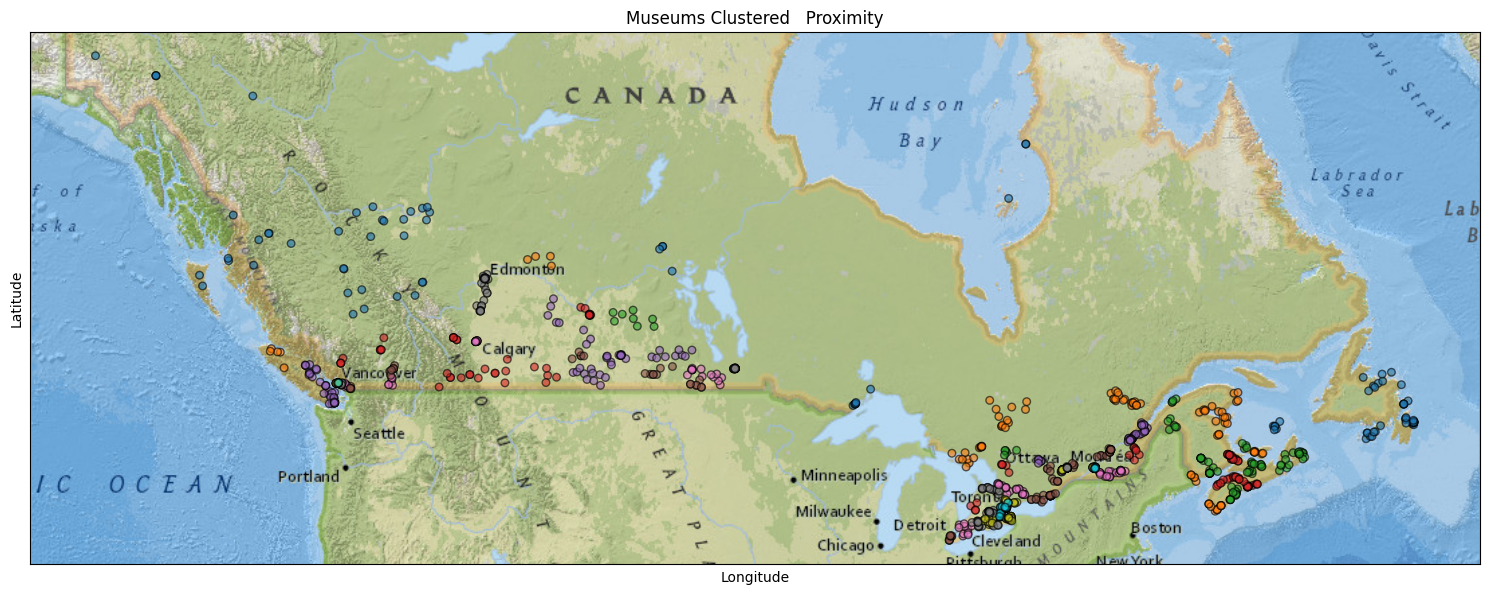

In [126]:
plot_clustered_locations(df, title='Museums Clustered   Proximity')